In [1]:
%%capture
!git clone https://github.com/naitik-2006/ml4sc

# Import Stuff

In [2]:
import os
import time
import random
import numpy as np
import torch
import cv2
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import timm  # timm library provides many pretrained models including hybrid ViT
from tqdm import tqdm  # for progress bars
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from torch.optim.lr_scheduler import OneCycleLR

# Variables

In [3]:
BATCH_SIZE = 32
train_dir = "/kaggle/working/ml4sc/dataset/train"
test_dir = "/kaggle/working/ml4sc/dataset/val"

# Physics Features

In [4]:
# Inspired from svjLucas work

class PhysicsInformedFeatures:
  def __init__(self,profile_size,min_angle_vision=-3.232, max_angle_vision=3.232):
    """
    Initialize the PhysicsInformedFeatures.

    This class provides a Physics Informed process to get Features of Gravitational
    Lensing Images.

    Parameters:
        profile_size (int): Size of the image profile (width or height in pixels).
        min_angle_vision (float, optional): Minimum vision angle in arcseconds in the images.
                                            Defaults to -3.232.
        max_angle_vision (float, optional): Maximum vision angle in arcseconds in the images.
                                            Defaults to 3.232.

    Raises:
        ValueError: If profile_size is not a positive integer greater than 1.
        ValueError: If min_angle_vision is greater than or equal to max_angle_vision.
    """

    # Check if the profile_size is a positive integer greater than 1
    if not isinstance(profile_size, int) or profile_size <= 1:
        raise ValueError("profile_size must be a positive integer bigger than 1")

    # Check if min_angle_vision is less than max_angle_vision
    if min_angle_vision >= max_angle_vision:
        raise ValueError("min_angle_vision must be less than max_angle_vision")

    # Store the image profile size, min_angle_vision, and max_angle_vision as class attributes
    self.profile_size = profile_size
    self.min_angle_vision = min_angle_vision
    self.max_angle_vision = max_angle_vision

    # Generate coordinate grids for image positions
    self.x = np.linspace(min_angle_vision, max_angle_vision, profile_size)
    self.y = np.linspace(min_angle_vision, max_angle_vision, profile_size)

    # Calculate the pixel width of the image
    self.pixel_width = self.x[1] - self.x[0]

  def plot_image(self,matrix,title=None,cmap='inferno', show_ticks_multiple_of=30,colorbar=True,axis=False,vmax=None,vmin=None):

    """
    Plot a matrix with customized ticks and visualizations.

    Parameters:
      matrix (numpy.ndarray): The input matrix to be plotted.
      title (str): The title of the plot.
      cmap (str, optional): The colormap to be used for visualization. Defaults to 'inferno'.
      min_angle_vision (float, optional): The minimum angle of vision for ticks. Defaults to -3.232.
      max_angle_vision (float, optional): The maximum angle of vision for ticks. Defaults to 3.232.
      show_ticks_multiple_of (int, optional): The interval for displaying tick marks. Defaults to 30.
      colorbar (bool, optional): A boolean that determines whether to include a colorbar in the graph or not. Defaults to True.
      axis (bool, optional): A boolean that determines whether to include the axis in the graph or not. Defaults to False.
      vmax (float, optional): The maximum value to be used for color normalization. Defaults to None.
      vmin (float, optional): The minimum value to be used for color normalization. Defaults to None.
    """

    # Calculate the center coordinates of the image
    height, width = matrix.shape[:2]
    center_x, center_y = width / 2, height / 2

    # Create tick positions and labels
    x_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, width+1)
    y_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, height+1)
    x_tick_labels = np.round(100*x_ticks * center_x/75).astype(int)/100
    y_tick_labels = np.round(100*y_ticks * center_y/75).astype(int)/100

    # Plot the image with centered coordinates and updated ticks
    if vmax is None and vmin is None:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap)
    elif vmax is not None and vmin is None:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap,vmax=vmax)
    elif vmax is None and vmin is not None:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap,vmin=vmin)
    else:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap,vmax=vmax,vmin=vmin)
    # Set the number of ticks on each axis
    plt.xticks(np.linspace(-center_x, center_y, width+1)[::show_ticks_multiple_of], x_tick_labels[::show_ticks_multiple_of])
    plt.yticks(np.linspace(-center_x, center_y, width+1)[::show_ticks_multiple_of], y_tick_labels[::show_ticks_multiple_of])

    if not axis:
      plt.axis('off')
    if title:
      plt.title(title)
    if colorbar:
      plt.colorbar()
    plt.show()

  def get_sersic_bn_constant(self, n):
    """
    Compute the Sersic index bn constant for the given Sersic index (n).

    The Sersic index (n) characterizes the radial profile of a galaxy or light distribution.
    This function calculates the bn constant used in the Sersic profile formula, which
    relates the Sersic index (n) to the effective radius and surface brightness of a galaxy.

    Parameters:
        n (float): Sersic index. A higher value of n corresponds to a more concentrated profile.

    Returns:
        float: The Sersic index bn constant calculated using the provided Sersic index (n).
    """
    # Calculate the bn constant using the Sersic index (n) formula
    bn = 1.999 * n - 0.327

    return bn

  def sersic_profile(self, x, y, x0=0.0, y0=0.0, theta=0.0, q=0.7522, n=1.0, r_ser=0.30, I0=1.0):
    """
    Generate the intensity distribution of light in an elliptical galaxy using Sersic profile.

    Parameters:
      x, y : 2D numpy arrays denoting the x and y coordinates.
      x0, y0: Floats representing the center of the ellipse.
      theta: Float for the rotation angle in radians.
      q: Float for the axis ratio of the ellipse.
      n: Float for the Sersic index.
      r_ser: Float for the Sersic radius.
      I0: Float for the central surface brightness.

    Returns:
      Is: 2D numpy array representing the intensity distribution.
    """
    # Calculating the radii from the center of the ellipse
    R = np.sqrt(((np.cos(theta)*(x-x0) + np.sin(theta)*(y-y0))**2
                 + (q**2)*((np.sin(theta)*(x-x0) - np.cos(theta)*(y-y0))**2))/q)

    # Calculate the constant bn based on the Sersic index
    bn = self.get_sersic_bn_constant(n)

    # Calculate the intensity at each point (x, y) based on the Sersic profile
    Is = I0*np.exp(-bn*((R/r_ser)**(1/n)))
    return Is

  def residuals(self, params, x, y, sersic_observed):
    """
    Compute the residuals of the observed Sersic profile and the model Sersic profile.

    Parameters:
      params : List of parameters for the Sersic profile [x0, y0, theta, q, n, r_ser].
      x, y : 2D numpy arrays denoting the x and y coordinates.
      sersic_observed : 2D numpy array for the observed Sersic profile.

    Returns:
      residuals : 1D numpy array of residuals.
    """
    x0, y0, theta, q, n, r_ser = params
    sersic_model = self.sersic_profile(x, y, x0, y0, theta, q, n, r_ser, I0=1.0)
    return (sersic_model - sersic_observed).ravel()

  def fit_sersic_profile(self, x, y, sersic_observed, initial_guess):
    """
    Fit a Sersic profile to observed data.

    Parameters:
      x, y : 2D numpy arrays denoting the x and y coordinates.
      sersic_observed : 2D numpy array for the observed Sersic profile.
      initial_guess : List of initial guesses for the parameters [x0, y0, theta, q, n, r_ser].

    Returns:
      optimal_params : List of optimal parameters [x0, y0, theta, q, n, r_ser].
    """
    # Bounds for parameters, q is constrained to be between 0 and 1
    bounds = ([self.min_angle_vision, self.min_angle_vision, 0, 0, 0.5, 0.1],
              [self.max_angle_vision, self.max_angle_vision, np.pi, 1, 10.0, 3.0])
    result = least_squares(self.residuals, initial_guess, args=(x, y, sersic_observed), bounds=bounds)
    return result.x

  def estimate_parameters(self, x, y, source_profile, profile_size):
    """
    Estimate parameters for a given profile.

    Parameters:
        x (numpy.ndarray): The x-coordinates of the profile.
        y (numpy.ndarray): The y-coordinates of the profile.
        source_profile (numpy.ndarray): The source profile to estimate parameters from.
        profile_size (int): The size of the profile.

    Returns:
        tuple: A tuple containing the estimated parameters x0, y0, theta, q, n, and r_ser.
    """
    # Creating a meshgrid of x and y coordinates
    Y, X = np.meshgrid(x, y)

    # Fitting the Sersic profile to the meshgrid data
    x0, y0, theta, q, n, r_ser = self.fit_sersic_profile(X.ravel(), Y.ravel(), source_profile.ravel(), initial_guess=[0, 0, 0, 1, 0.5, 1])

    # Returning the estimated parameters
    return x0, y0, theta, q, n, r_ser

  def reconstruct_source(self, image_profile, normalize = True, k=1):
    """
    Reconstructs the source from an image of a gravitationally lensed object.

    Parameters:
      image_profile (2D np.array): 2D array representing the brightness of the image.
      normalize (bool, optional): If the reconstructed_source must be normalized.  Defaults to True.
      k (float, optional): Gravitational lensing parameter. Defaults to 1.

    Returns:
      reconstructed_source (2D np.array): The reconstructed source image.
    """

    # Check if image_profile.shape[0] and image_profile.shape[1] is equal to profile_size
    if image_profile.shape[0]!=self.profile_size or image_profile.shape[1]!=self.profile_size:
        raise ValueError(f"The shape of the image_profile must be equal to (profile_size,profile_size)=({self.profile_size,self.profile_size})")

    # Calculating the half of the profile size
    half_profile_size = int(self.profile_size / 2)

    # Initialize the array for the image coordinates
    image_coords = []

    # Generate image coordinates based on the profile size and pixel width
    for x_index in range(-half_profile_size, half_profile_size):
        for y_index in range(-half_profile_size, half_profile_size):
            image_coords.append((x_index * self.pixel_width, y_index * self.pixel_width))

    # Initialize the array for the reconstructed source
    reconstructed_source = np.zeros((self.profile_size, self.profile_size))

    # Iterate over all coordinates in the lensed image
    for x_coord, y_coord in image_coords:
        # Skip the center of the lens
        if x_coord != 0 or y_coord != 0:
            # Calculate the new source coordinates using the lens equation
            # Supposing Singular Isothermal Sphere
            x_source = (x_coord - k * x_coord / np.sqrt(x_coord**2 + y_coord**2))
            y_source = (y_coord - k * y_coord / np.sqrt(x_coord**2 + y_coord**2))

            # Convert the source coordinates to index coordinates
            x_source_index = int(((x_source / self.pixel_width) + half_profile_size))
            y_source_index = int(((y_source / self.pixel_width) + half_profile_size))

            x_image_index = int((x_coord / self.pixel_width) + half_profile_size)
            y_image_index = int((y_coord / self.pixel_width) + half_profile_size)

            # Update the pixel value in the reconstructed source
            if reconstructed_source[x_source_index][y_source_index] == 0:
                reconstructed_source[x_source_index][y_source_index] = image_profile[x_image_index][y_image_index]
            else:
                # The Singular Isothermal Sphere can have two images, in this case, we take the average
                reconstructed_source[x_source_index][y_source_index] = (reconstructed_source[x_source_index][y_source_index] + image_profile[x_image_index][y_image_index]) / 2

    if normalize:
      # Normalize the reconstructed source
      reconstructed_source = reconstructed_source / reconstructed_source.max()

    return reconstructed_source

  def parameterize_reconstructed_source(self,reconstructed_source,normalize = True):

    """

    Estimates the parameters of the Sersic profile for a reconstructed galaxy source.

    Parameters:
      reconstructed_source (2D np.array): 2D array of the reconstructed source.
      normalize (bool, optional): If the reconstructed_source must be normalized.  Defaults to True.

    Returns:
      tuple: Estimated Sersic parameters (x0, y0, theta, q, n, r_ser) and the estimated source profile (2D np.array).

    """

    # Check if reconstructed_source.shape[0] and reconstructed_source.shape[1] is equal to profile_size
    if reconstructed_source.shape[0]!=self.profile_size or reconstructed_source.shape[1]!=self.profile_size:
        raise ValueError(f"The shape of the reconstructed_source must be equal to (profile_size,profile_size)=({self.profile_size,self.profile_size})")


    # Estimate parameters using the function 'estimate_parameters'
    x0, y0, theta, q, n, r_ser = self.estimate_parameters(self.x, self.y, reconstructed_source,self.profile_size)

    sersic_parameters = {'x0':x0,'y0':y0,'theta':theta,'q':q,'n':n,'r_ser':r_ser}

    # Get the maximum intensity I0:
    I0 = reconstructed_source.max()

    # Initialize array for storing Sersic profile intensities
    sersic_intensities = []

    # Calculate the Sersic profile for all coordinates
    for x_coord in self.x:
        for y_coord in self.y:
            intensity = self.sersic_profile(x_coord, y_coord, x0, y0, theta, q, n, r_ser, I0=I0)
            sersic_intensities.append(intensity)

    # Convert the list of intensities to a 2D array
    parameterized_source = np.array(sersic_intensities).reshape(self.profile_size, self.profile_size)

    if normalize:
      parameterized_source = parameterized_source/parameterized_source.max()

    return sersic_parameters, parameterized_source

  def compute_gradient_in_one_direction(self, matrix):

      """
      Compute the gradient in one direction (x or y) for the given matrix, using fifth order finite difference.

      Parameters:
          matrix (numpy.ndarray): Input matrix for which the gradient needs to be computed.

      Returns:
          numpy.ndarray: The gradient of the matrix in one direction.
      """

      # The step used to calculate the gradient
      h = self.pixel_width

      # Compute the forward difference for all but the last four rows
      forward_diff = (-25 * matrix[:-4] + 48 * matrix[1:-3] - 36 * matrix[2:-2] + 16 * matrix[3:-1] - 3 * matrix[4:]) / (12 * h)

      # Compute the backward difference for the last four rows
      backward_diff = (25 * matrix[-4:] - 48 * matrix[-5:-1] + 36 * matrix[-6:-2] - 16 * matrix[-7:-3] + 3 * matrix[-8:-4]) / (12 * h)

      # Concatenate the forward and backward differences to get the gradient for the whole matrix
      gradient = np.concatenate((forward_diff, backward_diff), axis=0)

      return gradient

  def compute_gradient(self, matrix):

      """

      Compute the gradient in both x and y directions for the given matrix.

      This function calculates the gradient of the input matrix in both the x and y directions
      using the forward difference method along one direction and its transpose along the other.

      Parameters:
          matrix (numpy.ndarray): Input matrix for which the gradient needs to be computed.

      Returns:
          tuple: A tuple containing two numpy.ndarray objects representing the gradients
                  in the x and y directions, respectively.
      """
      # Compute the gradient in the x direction
      gradient_x = self.compute_gradient_in_one_direction(matrix)

      # Compute the gradient in the y direction
      # To do this, we transpose the matrix to switch the x and y axes,
      # compute the gradient using the same method, then transpose the result back
      gradient_y = self.compute_gradient_in_one_direction(matrix.T).T

      return gradient_x, gradient_y

  def estimate_distorsions_in_gravitational_potential(self, image_profile, serninc_params, post_process=True, quantile=0.985):

      """
      Estimate the distortion in the gravitational potential given an image of a galaxy being lensed
      and the set of Sersic Parameters of this source.

      This method calculates an estimate of the distortion map resulting from the gravitational lensing effect
      on a given galaxy image and its associated Sersic parameters, which describe the light distribution of the galaxy.

      Parameters:
          image_profile (numpy.ndarray): 2D array representing the image profile of the object.
          sersic_params (dict): A dictionary containing the following Sersic parameters:
                                - 'x0' (float): X-coordinate of the center of the light distribution.
                                - 'y0' (float): Y-coordinate of the center of the light distribution.
                                - 'theta' (float): Orientation angle of the light distribution (in radians).
                                - 'q' (float): Axis ratio of the light distribution (minor/major axis).
                                - 'n' (float): Sersic index characterizing the radial profile.
                                - 'r_ser' (float): Effective radius of the light distribution.
          post_process (bool, optional): Whether to apply post-processing for better visualization and preparation
                                          for machine learning models. Defaults to True.
          quantile (float, optional): The quantile value to be used for normalization during post-processing.
                                      Defaults to 0.985.

      Returns:
          numpy.ndarray: The distortion map caused by the gravitational field for the given Sersic parameters.
                          If post_process is True, the map is post-processed for visualization and
                          better machine learning preparation.
      """

      # Check if image_profile.shape[0] and image_profile.shape[1] is equal to profile_size
      if image_profile.shape[0]!=self.profile_size or image_profile.shape[1]!=self.profile_size:
        raise ValueError(f"The shape of the image_profile must be equal to (profile_size,profile_size)=({self.profile_size,self.profile_size})")

      # Extracting Sersic parameters from the input dictionary
      x0 = serninc_params['x0']
      y0 = serninc_params['y0']
      theta = serninc_params['theta']
      q = serninc_params['q']
      n = serninc_params['n']
      r_ser = serninc_params['r_ser']

      # Calculate the maximum pixel value in the image profile
      I0 = image_profile.max()

      # Assign the image profile data to I
      I = image_profile

      # Calculate the Sersic bn constant using the provided Sersic index (n)
      bn = self.get_sersic_bn_constant(n)

      # Calculate the Sersic radius R based on the image profile data and Sersic parameters
      R = (r_ser * ((1 / bn) * np.log(I0 / I)) ** n) ** 2

      # Compute the first derivatives of R in the x and y directions
      Rx, Ry = self.compute_gradient(R)

      # Compute the second derivatives of R in the x direction (Rxx and Rxy)
      Rxx, Rxy = self.compute_gradient(Rx)

      # Compute the second derivatives of R in the y direction (Ryx and Ryy)
      Ryx, Ryy = self.compute_gradient(Ry)

      # Calculate the average of the mixed second derivatives
      gravitational_distorsions = (Rxy + Ryx) / 2

      # Check if post-processing is required
      if not post_process:
          # Return the raw mixed partial derivative without any post-processing
          return gravitational_distorsions
      else:
          # We avoid taking the maximum value for normalization due to the very high values near the singularities
          norm = np.quantile(gravitational_distorsions, quantile)

          # Normalize the mixed partial derivative using the quantile value
          gravitational_distorsions = gravitational_distorsions / norm

          # Saturate the biggest distortion to better see other distortions in the image
          gravitational_distorsions = np.tanh(gravitational_distorsions)

          # Using the absolute value to avoid numerical issues that appear due to the finite difference discretization
          gravitational_distorsions = np.abs(gravitational_distorsions)

          # Return the post-processed convergence map
          return gravitational_distorsions


  def improve_resolution(self, image, final_image_size=150):

      """

      Improve the resolution of an image using interpolation.

      This method increases the resolution of the input image using interpolation,
      thereby improving the image's quality and providing a higher-resolution output.

      Parameters:
          image (numpy.ndarray): 2D array representing the original image.
          final_image_size (int, optional): The desired size of the final image after resolution improvement.
                                            Defaults to 150.

      Returns:
          numpy.ndarray: The improved image with the desired final resolution.
      """

      # Create a 2D interpolator for the input image
      interpolator = interpolate.RectBivariateSpline(self.x, self.y, image)

      # Generate new coordinate grids for the desired final image size
      xi = np.linspace(self.min_angle_vision, self.max_angle_vision, final_image_size)
      yi = np.linspace(self.min_angle_vision, self.max_angle_vision, final_image_size)

      # Interpolate the image at the new coordinate grids to improve resolution
      interpolated_image = interpolator(xi, yi)

      return interpolated_image

  def plot_features(self,image_profile, reconstructed_source, estimated_source_profile, gravitational_distorsions,
                    sersic_params,cmap_source_galaxy='inferno', cmap_distorsions='hot', figsize=(15, 5), main_title=''):
      """
      Plot various features related to gravitational lensing.

      This function plots multiple images related to gravitational lensing to provide visual insights.

      Parameters:
          image_profile (numpy.ndarray): 2D array representing the original gravitational lensing image.
          reconstructed_source (numpy.ndarray): 2D array representing the reconstructed source image.
          estimated_source_profile (numpy.ndarray): 2D array representing the parameterized source image.
          gravitational_distorsions (numpy.ndarray): 2D array representing the distortions in the gravitational potential.
          sersic_params (dict): A dictionary containing the following Sersic parameters:
                                - 'x0' (float): X-coordinate of the center of the light distribution.
                                - 'y0' (float): Y-coordinate of the center of the light distribution.
                                - 'theta' (float): Orientation angle of the light distribution (in radians).
                                - 'q' (float): Axis ratio of the light distribution (minor/major axis).
                                - 'n' (float): Sersic index characterizing the radial profile.
                                - 'r_ser' (float): Effective radius of the light distribution.
          cmap_source_galaxy (str, optional): The colormap to be used for galaxy-related images.
                                              Defaults to 'inferno'.
          cmap_distorsions (str, optional): The colormap to be used for gravitational distortions image.
                                            Defaults to 'hot'.
          figsize (tuple, optional): The size of the plot figure. Defaults to (15, 5).
          main_title (str, optional): The main title to be displayed above the subplots. Defaults to an empty string.
      """

      # Prepare a list of dictionaries containing image data and titles for each image to be plotted
      images = [
          {'img': image_profile, 'cmap': cmap_source_galaxy, 'title': 'Gravitational Lensing Image'},
          {'img': reconstructed_source, 'cmap': cmap_source_galaxy, 'title': 'Reconstructed Galaxy (Source)'},
          {'img': estimated_source_profile, 'cmap': cmap_source_galaxy, 'title': 'Parameterized Sersic Galaxy'},
          {'img': gravitational_distorsions, 'cmap': cmap_distorsions, 'title': 'Distortions in Gravitational Potential'}
      ]

      # Calculate the center coordinates of the image
      height, width = image_profile.shape[:2]
      center_x, center_y = width / 2, height / 2

      # Create tick positions and labels
      x_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, width)
      y_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, height)
      x_tick_labels = np.array([int(100 * self.min_angle_vision) / 100, 0, int(100 * self.max_angle_vision) / 100])
      y_tick_labels = np.array([int(100 * self.min_angle_vision) / 100, 0, int(100 * self.max_angle_vision) / 100])

      # Calculate the step size for tick positions
      step_size_x = max(1, len(x_ticks) // 3)
      step_size_y = max(1, len(y_ticks) // 3)

      # Create a 1x4 grid of subplots
      fig, axes = plt.subplots(1, 4, figsize=figsize)

      for i, (ax, image) in enumerate(zip(axes, images)):
          # Plot each image in the corresponding subplot
          ax.imshow(image['img'], cmap=image['cmap'], extent=[-center_x, center_x, -center_y, center_y])
          ax.set_title(image['title'])

          # Set the number of ticks on each axis and corresponding labels
          ax.set_xticks(np.linspace(-center_x, center_y, num=3))
          ax.set_xticklabels(x_tick_labels)

          ax.set_yticks(np.linspace(-center_x, center_y, num=3))
          ax.set_yticklabels(y_tick_labels)
          ax.set_xlabel('x [arcsec]')

          # For the first subplot, add the ylabel, for the rest, hide y-axis
          if i == 0:
              ax.set_ylabel('y [arcsec]')
          else:
              ax.yaxis.set_visible(False)

      # Add the main title above the subplots
      plt.suptitle(main_title,fontweight='bold')

      # Add the additional label to explain the Sersic parameters
      fig.text(0.5, 0.88, 'Estimated Sersic Galaxy Parameters', ha='center', fontsize=11)

      # Extracting parameters from the dictionary
      x0 = sersic_params['x0']

      # The minus the the next line is due to the y-axis be inverted in the optimization
      y0 = -sersic_params['y0']

      theta = sersic_params['theta']
      q = sersic_params['q']
      n = sersic_params['n']
      r_ser = sersic_params['r_ser']

      # Format each variable to have two decimal digits
      x0_str = f"{x0:.2f}"
      y0_str = f"{y0:.2f}"
      theta_str = f"{theta:.2f}"
      q_str = f"{q:.2f}"
      n_str = f"{n:.2f}"
      r_ser_str = f"{r_ser:.2f}"

      # Creating a LaTeX-formatted string
      latex_string = f"$x_0 = {x0_str} y_0 = {y0_str} \theta = {theta_str} q = {q_str} n = {n_str} R_\mathrm{{ser}} = {r_ser_str}$"

      # Add the additional label below the main title
      fig.text(0.5, 0.85, latex_string, ha='center', fontsize=10)

      plt.show()

# Custom Dataset

In [5]:
# Initialize PhysicsInformedFeatures
physics = PhysicsInformedFeatures(profile_size=150, min_angle_vision=-3, max_angle_vision=3)

In [6]:
class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with subfolders per class (e.g., ./train/class_name/)
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.samples = []  # list of tuples (file_path, label)
        self.transform = transform

        # List subdirectories and assign integer labels
        class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_folder):
                if fname.endswith('.npy'):
                    file_path = os.path.join(class_folder, fname)
                    self.samples.append((file_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load and preprocess the data
        data = np.load(file_path)
        if data.ndim == 3 and data.shape[0] == 1:
            # Single-channel image detected (H, W) or (H, W, 1)
            clipped_data = np.clip(data, 1e-8, 1).reshape(150, 150)

            # Initialize PhysicsInformedFeatures
            physics = PhysicsInformedFeatures(profile_size=150, min_angle_vision=-3, max_angle_vision=3)

            # Generate the reconstructed source
            cdm_reconstruct_source = physics.reconstruct_source(clipped_data, k=1).reshape(150, 150)

            # Create a 3-channel image: (original, original, reconstructed)
            combined_image = np.stack([clipped_data, clipped_data, cdm_reconstruct_source], axis=-1)
            data = torch.tensor(combined_image.transpose(2, 0, 1), dtype=torch.float)

            # Save the 3-channel image to the same path
            np.save(file_path, data)
        elif data.ndim == 3 and data.shape[-1] ==3:
            data = torch.tensor(data.transpose(2, 0, 1), dtype=torch.float)
            # Save the 3-channel image to the same path
            np.save(file_path, data)
            
            
        data = torch.tensor(data, dtype=torch.float)
        return data, label

# Data Augmentation

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),                         # Horizontal flip
    transforms.RandomVerticalFlip(),                           # Vertical flip
])

# Utility Function

In [8]:
# ---------------------------
# Utility: Visualize Sample Images from DataLoader
# ---------------------------

def show_sample_images(data_loader, class_names, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_images]
    labels = labels[:num_images]
    # Convert tensor from C x H x W to H x W x C for plotting
    images = images.permute(0, 2, 3, 1).cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(np.clip(images[i][:, : , 0], 0, 1))
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis('off')
    plt.show()

# Model

In [26]:
def get_model(num_classes=3):
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)

    # Get the number of input features to the classifier
    in_features = model.get_classifier().in_features

    # Remove the last classification layer and add custom layers
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.3),
        nn.Linear(in_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, num_classes),
    )
    return model

In [27]:
# Freeze and Unfreeze Backbone

def freeze_backbone(model):
    # Freeze all parameters except the classification head (assumed to contain 'head' in name)
    unfreeze_backbone(model)
    for name, param in model.named_parameters():
        if 'classifier' not in name:
            param.requires_grad = False
        else :
          break

def unfreeze_backbone(model):
    for param in model.parameters():
        param.requires_grad = True

In [28]:
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Apply softmax for probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = np.argmax(y_scores, axis=1)

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Classification Report
    print('Classification Report:\n', classification_report(y_true, y_pred))

    # Compute ROC Curve and AUC Score
    plt.figure(figsize=(8, 6))
    for i in range(y_scores.shape[1]):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return accuracy

In [29]:
# Training Loop with tqdm, Cosine Annealing Scheduler & Loss Logging

def train_model(model, train_loader, test_loader, num_epochs=15, device='cuda', save_path='./saved_models'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)  # AdamW for better weight decay handling

    # OneCycleLR dynamically adjusts learning rate
    steps_per_epoch = len(train_loader)  # Total steps per epoch
    scheduler = OneCycleLR(
        optimizer,
        max_lr=5e-3,  # Peak learning rate (tune this)
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,  # First 10% of training: LR increases
        anneal_strategy="cos",
        final_div_factor=100  # Final LR = max_lr / 100
    )

    # Freeze backbone for initial epochs
    freeze_backbone(model)
    print(f"Pretrained backbone frozen for first epochs.")

    # Create directory to save models
    os.makedirs(save_path, exist_ok=True)

    loss_history = []
    epoch_times = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        epoch_start_time = time.time()
        images_count = 0

        # Training loop with tqdm progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            images_count += images.size(0)

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            train_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{(correct_train / total_train) * 100:.2f}%",
                "LR": f"{scheduler.get_last_lr()[0]:.6f}"  # Show changing LR
            })

        epoch_loss = running_loss / images_count
        loss_history.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        # Save model after each epoch
        model_save_path = os.path.join(save_path, f"model_epoch.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved: {model_save_path}")

        # Unfreeze backbone after freeze_epochs and update scheduler
        if epoch+1 == 1:
            unfreeze_backbone(model)
            print("Unfreezing pretrained backbone. Now training the entire model.")
        if epoch+1 > 1:
            scheduler.step()

        evaluate_model(model, test_loader, device)

    # Plot training loss vs. epochs
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss vs. Epochs")
    plt.grid(True)
    plt.show()

    return loss_history, epoch_times

# Main Code

In [30]:
train_dataset = NpyDataset(train_dir, transform=train_transform)
test_dataset = NpyDataset(test_dir)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = list(train_dataset.class_to_idx.keys())

In [ ]:
# Plot distribution of classes in the training set

class_counts = {cls: 0 for cls in train_dataset.class_to_idx.keys()}
for _, label in train_dataset:
    for cls, idx in train_dataset.class_to_idx.items():
        if label == idx:
            class_counts[cls] += 1

plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Training Data Distribution")
plt.show()

Showing sample images from training data:


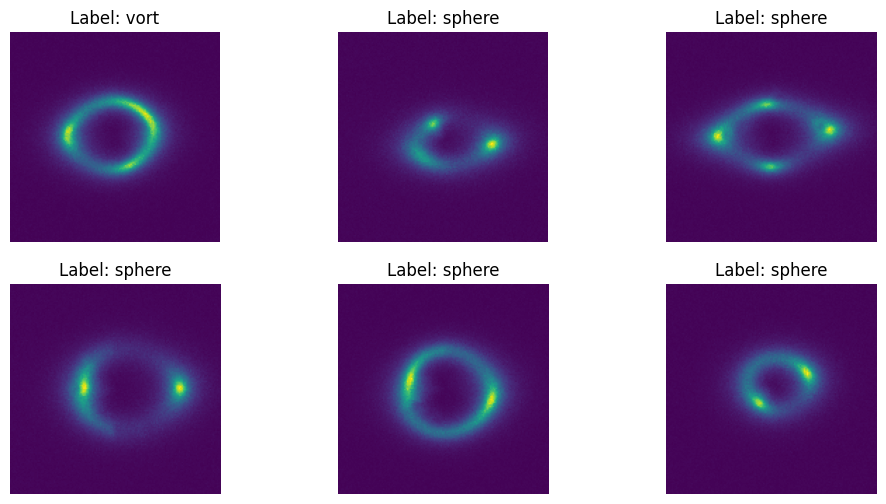

Showing sample images from test data:


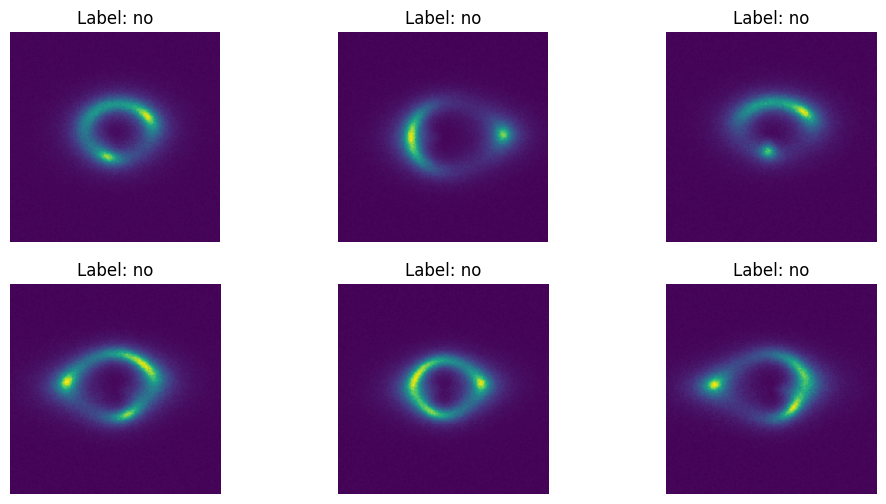

In [31]:
# Visualize sample images from train and test to ensure DataLoader works
print("Showing sample images from training data:")
show_sample_images(train_loader, class_names, num_images=6)
print("Showing sample images from test data:")
show_sample_images(test_loader, class_names, num_images=6)

In [32]:
# Get the pretrained model
model = get_model()

In [ ]:
# Train the model with freezing + cosine annealing
loss_history, epoch_times = train_model(model, train_loader, test_loader, num_epochs=25,  device='cuda')

Pretrained backbone frozen for first epochs.


Epoch [1/25]:  69%|██████▉   | 647/938 [00:15<00:07, 40.65it/s, Loss=1.0666, Acc=36.24%, LR=0.000200]

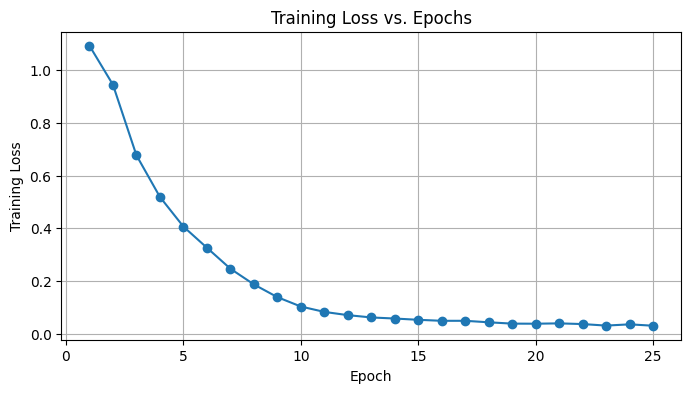

In [34]:
# Plot training loss vs. epochs
plt.figure(figsize=(8, 4))
plt.plot(range(1,25+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs")
plt.grid(True)
plt.show()

Accuracy: 0.8353
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      2500
           1       0.79      0.80      0.80      2500
           2       0.85      0.86      0.85      2500

    accuracy                           0.84      7500
   macro avg       0.84      0.84      0.84      7500
weighted avg       0.84      0.84      0.84      7500



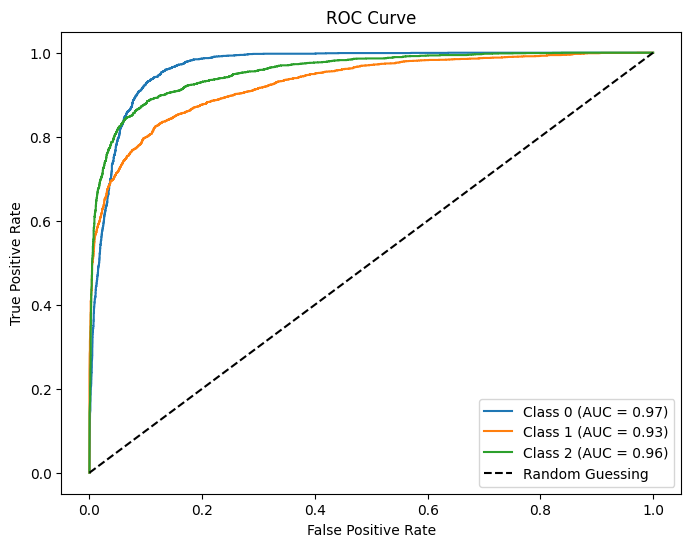

0.8353333333333334

In [35]:
evaluate_model(model, test_loader, "cuda")